In [5]:
import pandas as pd
import numpy as np
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, mean_absolute_error

import xgboost
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")
import random as rn
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from bayes_opt import BayesianOptimization
import os
import pickle

from helpers.utils import *
from helpers.xgboost_feval import *
from models.burningcrusade.data_preparation import prepare_data

In [6]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [7]:
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from sklearn.datasets import load_boston
import numpy as np

In [8]:
DIR = "/Users/brianbroeking/projects/numerai/data"
train_static, val_static, tournament_static = load_data(DIR, reduce_memory=True)
X_train, y_train = clean_for_xgboost(train_static)
X_tournament, y_tournament = clean_for_xgboost(tournament_static)
train, tournament = train_static.copy(), tournament_static.copy()

Loading the data


In [ ]:
# for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
#     features_list = [c for c in train.columns if str(c).startswith(f"feature_{group}")]
#     train, tournament = generate_polynomial_features(features_list, train, tournament)

In [5]:
# est_gp = SymbolicRegressor(population_size=5000,
#                            generations=20, stopping_criteria=0.01,
#                            p_crossover=0.7, p_subtree_mutation=0.1,
#                            p_hoist_mutation=0.05, p_point_mutation=0.1,
#                            max_samples=0.9, verbose=1,
#                            parsimony_coefficient=0.01, random_state=0)
# est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.52          3.59554        3         0.296719         0.296688     23.98m
   1     3.41         0.401732        1         0.176481         0.177222     15.93m
   2     1.58         0.349482        1         0.176405           0.1779     14.76m
   3     1.32         0.271459        1          0.17631         0.178758     14.64m
   4     1.37         0.295973        1         0.176303         0.178817     16.88m
   5     1.44         0.231865        1         0.176318         0.178681     15.59m
   6     1.40         0.231595        1         0.176326         0.178614     14.46m
   7     1.40         0.225686        1         0.176315         0.178712     13.23m
   8     1.40         0.231286        1         0.176311         0.178745  

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [14]:
def era_boost_train(X, y, era_col, proportion=0.5,
                    trees_per_step=10, num_iters=200,
                    one_shot=False, tree_method='hist',
                    test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    param = {
        'colsample_bytree': 0.1,
        'gamma': 0.1,
        'max_depth': 5,
        'min_child_weight': 19,
        'subsample': 1.0,
        'eta':0.001,
        'verbosity':0,
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': -1,
    }
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = xgboost.XGBRegressor(**param,
                                             n_estimators=trees_per_step,
                                             n_jobs=-1,
                                             tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            model = test_model
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            print(spearmanr(era_df["pred"], era_df["target"])[0])
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model

In [15]:
X_train

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
0,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,...,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75
1,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,...,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00
2,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,...,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75
3,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,...,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00
4,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.50,...,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,0.50,0.50,0.25,0.00,0.00,0.50,0.75,0.00,0.75,0.75,...,0.75,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.25,0.25
501804,1.00,0.00,0.00,1.00,0.50,0.75,0.75,1.00,0.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.75,1.00,1.00
501805,0.75,0.50,0.50,0.50,0.25,0.50,0.25,0.50,0.25,0.25,...,1.00,1.00,0.75,0.25,1.00,1.00,1.00,0.25,0.00,0.00
501806,0.25,0.25,0.25,0.50,0.00,1.00,1.00,0.50,0.25,0.25,...,0.50,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.25,0.75



#### Era boost train with proportion 0.500 ####

Train 20 iterations
Train 10 rounds per iteration

Iteration 1:

predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09225743741047578
0.0877931554662104
0.057171030816834445
0.07215655211120048
0.08483883390135
0.0774199089310384
0.05709625389785398
0.11264988393169224
0.009681970310690931
0.09246797774214806
0.07665510865081296
0.07692213311441966
0.05762214992785924
0.06429523113792271
0.04605669720941356
0.11810772225310329
0.0598005049257102
0.03575223833081345
0.06677913466586585
0.11030665336077432
0.04090049819324368
0.08535486865033641
0.08095212620646872
0.06782427698042007
0.05526362787707361
0.057101036749418875
0.0441758235077972
0.05492860993467507
0.08275382805619556
0.115473370633601
0.05378540226807913
0.06033501866760876
0.038848079092189375
0.051500045070159935
0.0634441424421861
0.08182705551619034
0.07509340942033305
0.08437658770401636
0.09531849899820992
0.03787863508817333
0.023591059044683345
0.04122731266938912
0.0626693297374239
0.09474441274929814
0.09219389507313981
0.04559330843574495
0.09687943453061829
0.07892052661827166
0.04599473334974802
0.

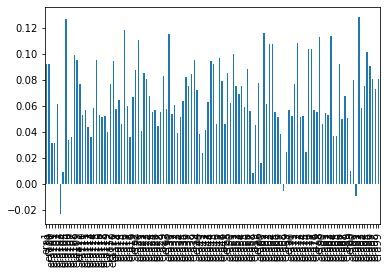

autocorrelation
0.011112454624168216
mean correlation
0.06461192239709197
sharpe
2.221242980587188
smart sharpe
2.1877257354207242

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08575082152975812
0.08591578078834165
0.07648127309669064
0.00913396924421228
0.04465751012170968
0.04013907339046672
0.10663692019770625
0.06443877337799625
0.05998416918039288
0.08400740067879627
0.04708020235056432
0.05254858760931399
0.10506339215520372
0.03556413076745277
0.1052168294392279
0.0947783452448007
0.11980223030162473
0.08681551943695606
0.029549961161320713
0.06468031977126758
0.09477721135475978
0.06468893772942354
0.03373002380688473
0.05346340425417551
0.05373115428545107
0.12076909494931558
0.09873828560853419
0.06521226023080574
0.03400348091723992
0.06790568660978494
0.0965743528407417
0.03258192195185356
0.09007699422990577
0.06435160865089785
0.00793203034846731
0.0648324715343127
0.03544948264602081
0.06267237636381363
0.08630040151534027
0.0887005724881966
0.051482797273041954
0.07799257856992522
0.05418601128902059
0.06769722674910733
0.060284022626232524
0.10034632631828078
0.06854496709738611
0.06397880116287835
0.08594582861352029

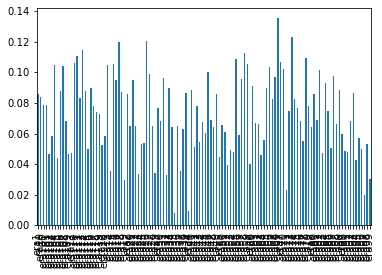

autocorrelation
0.06135063289022431
mean correlation
0.0719887753784255
sharpe
2.796743696393708
smart sharpe
2.620479511440944

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.06611091441109601
0.07963815105405912
0.06715555889870317
0.09985840966840984
0.11358577630155818
0.08585359645793021
0.06519087535712652
0.12778382629569215
0.05864677377352509
0.08591071633188264
0.10057042766260114
0.10435783391480974
0.05723422180172655
0.07829057687041685
0.07874098737500962
0.10242536262519501
0.061445771921828485
0.04610552905484928
0.08146423524821174
0.1117750138814349
0.050786408114719524
0.1191695436527407
0.10213040477766935
0.09441766070484463
0.09928908651780032
0.05519876341338192
0.028893491514191173
0.09381316813499903
0.08685014539592742
0.1375475435763443
0.06485287300043723
0.062267565676716076
0.0451146222688548
0.09896217354050826
0.07380420498069509
0.11290358367217514
0.08963115634585983
0.10506115313451542
0.07874785059892173
0.02924128075483928
0.04421847883987816
0.0436540512636699
0.08532470622073707
0.11237686014952505
0.10761914533039821
0.04586763752730421
0.07381101643370656
0.10951395707374162
0.0546977007806781

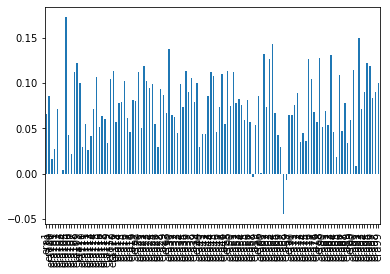

autocorrelation
0.06531027500271094
mean correlation
0.07279633738897354
sharpe
1.9572014388673
smart sharpe
1.8266341320604143

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12121898230605084
0.07112221054626984
0.06693552770914088
0.0712794457071986
0.0854778848878439
0.06800368087153669
0.09730518693257818
0.08616453431786746
0.08802504804941973
0.08691073664287696
0.09592925231503574
0.0868608000609538
0.07822457935855356
0.05956514542181245
0.0727725158653156
0.10630490720279878
0.10589701011762806
0.0826216742397963
0.05651964680691958
0.09270315133670594
0.08227958966196908
0.10085986894606455
0.07225464111647482
0.08384001438714316
0.07378178508486294
0.10099206352201759
0.06754607953422692
0.0706349877549139
0.06590155340264817
0.11510769624111268
0.08936099202402853
0.07765771336452465
0.08135685764742008
0.06753064348138794
0.049411085424749236
0.09890712836993339
0.0692400805238624
0.09271016261957093
0.07958836657915051
0.07177589361208779
0.06669797022928099
0.0784558489615382
0.061296863204065785
0.09829518195509626
0.10031304905854743
0.07706341163707733
0.06609713092595415
0.09862837785090812
0.07463673086012469
0.0

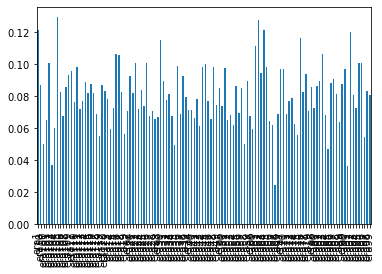

autocorrelation
-0.0025120814110855543
mean correlation
0.08055568320124798
sharpe
4.2826345560545125
smart sharpe
4.275390310208577

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12354322174821646
0.10337015721583571
0.09043545594356117
0.0996536799303125
0.07835398171732812
0.104489925073173
0.08101890390311298
0.08548365505757514
0.06255756895796363
0.08536916073370893
0.08288070047338153
0.07764217556512229
0.10967188439122934
0.08438285222123307
0.09701033773703731
0.10151412692058678
0.09594762836494343
0.0682136204263233
0.0896364396077573
0.09934337497294814
0.06544541687773216
0.09564169359094563
0.10370811633343868
0.0736436852777726
0.09888907810531605
0.08796239028482448
0.09103725283936163
0.10368704100425685
0.08877297574384728
0.10587816518422344
0.07043827602792854
0.09993078665806973
0.0791199181175004
0.08790816244938622
0.07585757743387518
0.09531261558284855
0.09498631265588346
0.08987591745768883
0.10277157497597211
0.09108389406871756
0.08023640779771757
0.08586202276285719
0.08250513085708945
0.08660583143217596
0.08837802666992194
0.10023270064713563
0.09295782444629408
0.08601883175077632
0.095523579481697
0.0966

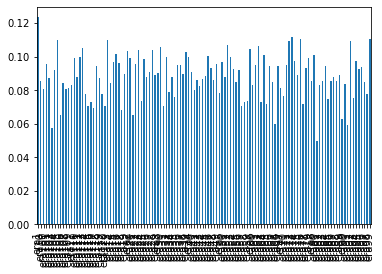

autocorrelation
-0.12160722087483354
mean correlation
0.08840954951120199
sharpe
6.690639623145796
smart sharpe
7.521080847332207

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10077291374881
0.08618943757939092
0.07191650750983543
0.09092404216662535
0.10868316440329968
0.09456576179342606
0.08230062086959698
0.10767888674137524
0.07600617511761949
0.10685902699625696
0.10288602011228201
0.09824912725862642
0.0878098025759459
0.100221371900312
0.08337437552049638
0.10539013659781346
0.08658376087390378
0.08518760540601752
0.0669197126511283
0.09297745312043265
0.08182470377775639
0.09527387198999822
0.09497919418056903
0.09862160178960211
0.07581251282728184
0.10986789372481558
0.07323531598604115
0.07399925462947607
0.07919987380650062
0.10193556859055837
0.09415865764223491
0.07408880388496401
0.09331158010410354
0.08070325785042959
0.09202404040044972
0.08824543959909538
0.07974721575531604
0.08566635778047003
0.10223025807628472
0.0755279243701401
0.08803901173601315
0.09182486010475223
0.0896732622783011
0.10809763871010458
0.11496599306159541
0.07835501860524365
0.08713334548226928
0.11634289967817148
0.07336190310257953
0.0775

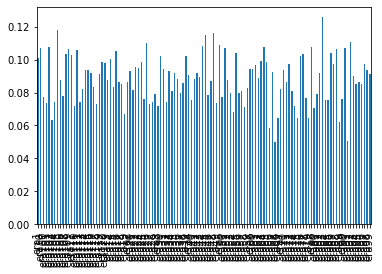

autocorrelation
-0.14365165224846588
mean correlation
0.08830953843867154
sharpe
6.095377553872718
smart sharpe
7.00607720156739

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1097955255792903
0.11024523203061228
0.0795201934611109
0.07831233149013284
0.09810971230913113
0.08310955351531409
0.10002675856348434
0.09024087736881967
0.09759858043670937
0.1056049449947634
0.0939903283962053
0.08343773550188072
0.10484154856543851
0.08276962901803299
0.09322119378879853
0.09257116591596036
0.10844288979979987
0.1016767440102272
0.07405606354784841
0.09207688787324705
0.0978897760993769
0.08194858884718241
0.08360531658016375
0.08623426353300465
0.08829389939693075
0.09214162910848919
0.09047331050677809
0.09830718425255167
0.09826034814606363
0.10253078227812945
0.0765006029426051
0.08904801216262234
0.08085294129195085
0.09990978751338307
0.07321904032124826
0.08440027728062595
0.09486428487984873
0.11004941421073425
0.09722894687108705
0.08813896328198584
0.09031947536465283
0.0754717920445798
0.07837220664573355
0.09766789792695653
0.09889460445266329
0.09553974278595616
0.10517355014609601
0.09796007135355321
0.08270874904827409
0.101

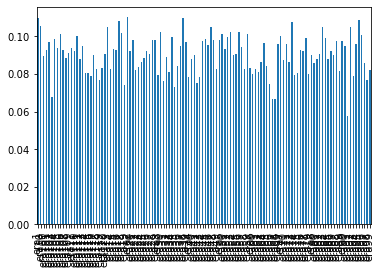

autocorrelation
0.04930998383848942
mean correlation
0.09054677540677956
sharpe
8.913706916489254
smart sharpe
8.45254982627716

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10408178328295994
0.09495080566256184
0.09554756482469678
0.098082427855431
0.09752102099317328
0.1012825680338242
0.08997182973668631
0.12045764623453438
0.07709156708688548
0.09994736397587371
0.09347099453209401
0.10940978626419305
0.09437442321393556
0.10040767044203458
0.08463416477091018
0.09438901534726947
0.09399544173548913
0.07628045550393608
0.09074455186572299
0.09311674600341406
0.07520869679299343
0.11070562155790839
0.10622073237942463
0.09808062723545231
0.10517937247795715
0.08050862871882115
0.09899290282692785
0.08804957535933713
0.08948856273291012
0.10511997095740573
0.09222815463583922
0.10126080131885355
0.09814322655945365
0.08240925160315414
0.09295297616646643
0.11065417546199052
0.09509636558164761
0.09714937252141835
0.08525477628696351
0.09552384069083733
0.09602380473225315
0.08350064286707269
0.10435842246940705
0.09121470274822345
0.09440809872408779
0.07659895885226951
0.09526433660820711
0.0951246686216642
0.09919685783961166
0

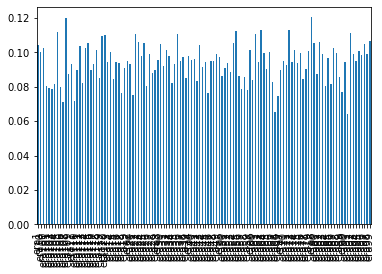

autocorrelation
0.01092278189340289
mean correlation
0.09405764406736664
sharpe
8.490317083348643
smart sharpe
8.36377640905215

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10612279764265176
0.08778097397874494
0.07354526359302775
0.094371831943712
0.09040670367598647
0.08489768515848921
0.09661595376488075
0.1018391216572791
0.08598816211377563
0.09787515576844652
0.1028437002371954
0.08296310371806934
0.10749556232069898
0.08094683544646493
0.08921508854153495
0.10866451254221546
0.10779780415805855
0.09956196016874622
0.08986734494154267
0.10062290978697824
0.08459304291560511
0.09311679400688953
0.0961104778854746
0.09254376744792954
0.0891037944485743
0.08970185790858426
0.08578747912941431
0.09175952297302725
0.1011123369194057
0.09731023818063285
0.09199240737328221
0.08495277129873476
0.07740051011125262
0.08818577187534533
0.0875634886644474
0.09860488069295163
0.07685764966996994
0.09577640473113556
0.10491154744475101
0.08491782562506699
0.07318844460340833
0.09420731922259573
0.08088193969221744
0.10390037361253701
0.10655392515079772
0.08701373159197545
0.0924555118720151
0.09342427649407406
0.07393297304821282
0.1020

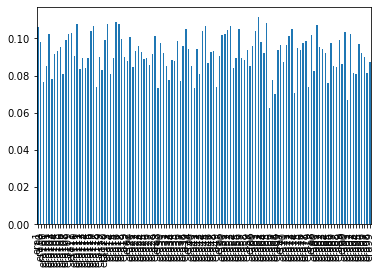

autocorrelation
-0.06552651551979072
mean correlation
0.09187776110043787
sharpe
8.918096061567889
smart sharpe
9.47797595502343

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10297399788352819
0.1003802466229058
0.09042933084538149
0.07897794700015255
0.11206923187900288
0.10601588446181094
0.08894405289106479
0.10098225730146923
0.08769747044936327
0.09709844420970933
0.09558583181886221
0.10345097212950552
0.0965641647746181
0.10040988248674133
0.10319922648796893
0.10759447780978529
0.09730436137003261
0.07630271473458677
0.10093052914724064
0.10130468208966985
0.09704780588564715
0.09463327880151942
0.08864967299605349
0.0826381153879032
0.09975268792781312
0.10095041206977294
0.09831147324876788
0.10839882831965726
0.09038630423092575
0.09504897941432676
0.10448042040335331
0.09678561868079241
0.09679556739762273
0.09002624408360804
0.09748549326778036
0.09796683384252591
0.09686910068205457
0.0907869343068778
0.09537892661135862
0.09475686502272807
0.08525049982659438
0.07760806013532888
0.1024801597679513
0.09943927849510928
0.09955236119393353
0.09328429138840667
0.0911126401932386
0.08829234691562339
0.09136993079265035
0.0

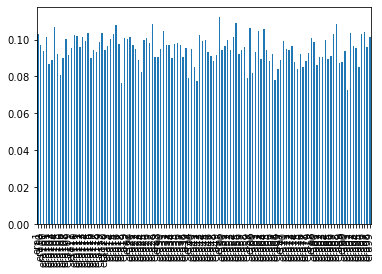

autocorrelation
0.049651421897720115
mean correlation
0.09482778456418008
sharpe
12.613603524857847
smart sharpe
11.956970627933382

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09561979324986919
0.09055700198356306
0.09923709560619076
0.10484573253682655
0.11285551736031611
0.09754257751690708
0.0942680890152382
0.0974781852023847
0.08998218286147702
0.09989470616951567
0.09575003851643528
0.09519516034737784
0.0943393968689265
0.0858130343161345
0.09339673641725178
0.10964909974842375
0.08904214325255612
0.09056828791883456
0.08942016001465791
0.09792836312855702
0.08500231485659006
0.11317475155948646
0.1106946665512854
0.09789439883817952
0.09616894689718056
0.09170265036454972
0.08539786797466845
0.09080603898509107
0.10216527385318362
0.11683666770755272
0.09040356160800589
0.07923256053119325
0.07797672899438383
0.09613619570923168
0.08602974762655215
0.096385628806907
0.08481644253161015
0.1025826492815408
0.09424466171826262
0.10254692188563148
0.08341740855599361
0.08497784856805224
0.08706423665183445
0.09450375552841943
0.0970596355194467
0.09690203477004308
0.10277869578703093
0.1086906161080149
0.09391508658348521
0.10433

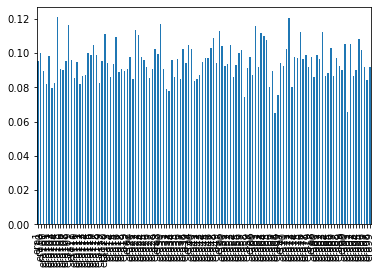

autocorrelation
0.024500458548407496
mean correlation
0.09495957848649983
sharpe
8.999437013218607
smart sharpe
8.746703344005725

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09651571660551185
0.11034975527405404
0.0885355946601055
0.08923181262707129
0.10269832562364663
0.09183903745313292
0.10818167092828064
0.08900834295374979
0.09704203290593183
0.09676787558254296
0.08586519884722367
0.08983785996659896
0.10016873858922964
0.09539589190114715
0.1086281452695177
0.10126484963968219
0.10736098714778727
0.10171434394426446
0.09282466353578338
0.09204659577527126
0.09662247632787913
0.10752217742598082
0.0983340958934029
0.08927386190156839
0.08223937520272062
0.1021051899096796
0.09975533546912248
0.10251169562298325
0.09376062439781689
0.10599370657549737
0.10049999008912444
0.09043318796275662
0.09624901842551108
0.08465936199691876
0.09025473873681844
0.0910410896422402
0.09756814152671278
0.09714074943539622
0.10510784296456721
0.09892552661649415
0.0950575968772889
0.09373196882284844
0.10202800479938623
0.09402063639195161
0.08958037697809886
0.08833466506670076
0.09522615492496397
0.0981111554373346
0.10347298489628715
0.10

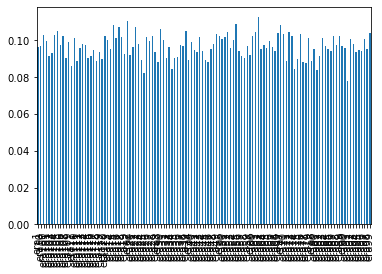

autocorrelation
0.0774622687822766
mean correlation
0.09687291836288472
sharpe
15.204679418706775
smart sharpe
14.019527595111153

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11102792730846059
0.10282112844157525
0.10003789121093039
0.10960952216034772
0.10635109551219735
0.10228236174091315
0.09425554461357388
0.10568673020872581
0.0858252657172793
0.10635734406273958
0.0981762465939641
0.10116017267830464
0.09607426637406247
0.10478655737442208
0.09877668217466604
0.10472278360395101
0.09310658584604156
0.09012991222932279
0.10238284848906555
0.11013623437063552
0.09861896356002092
0.10813739587657793
0.10168980842281529
0.10185940518143916
0.0985501038585475
0.0941963341525118
0.08565786748060905
0.09216196470327541
0.10891575796353531
0.11070692885924358
0.09227094373717024
0.09631944439175277
0.09560690773049223
0.09484795775414995
0.1031439401395381
0.10798525765434255
0.09343148994563884
0.09583621624524322
0.10225826090625896
0.08750108969029716
0.09232880913182218
0.10219820506669153
0.09141713220051574
0.10473924223048434
0.1031677836076644
0.09709880808296065
0.11004517650173837
0.0967043612935888
0.08894782385765862
0.08

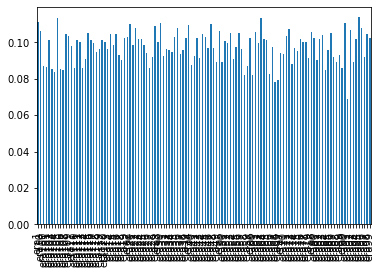

autocorrelation
-0.06479500763734439
mean correlation
0.09755690639123249
sharpe
11.451847453176638
smart sharpe
12.161934070184202

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10890686066535825
0.10012239907380198
0.09008814911431007
0.09760432837801945
0.10187199202942686
0.09708081478727927
0.10477984116654757
0.09513774298941849
0.09125556948064803
0.10258011243193009
0.10524256315271194
0.0929825910275556
0.1071875037950145
0.09699584258452666
0.11212245416003584
0.10030513877970415
0.1060773115484138
0.10009084935470003
0.08924720770516419
0.10176607590217882
0.10856097218590939
0.10376478677226456
0.0891666016887624
0.09692955152735541
0.10136319798353124
0.1053527331356043
0.09877702708574987
0.09933686039240842
0.09577735084669484
0.09926036825614265
0.10290383106293131
0.10380280467705874
0.10954688258876712
0.09546941915554855
0.08996486180253682
0.10133548379848112
0.09957241963237067
0.1053183035301037
0.10143915152653817
0.10280030771608582
0.10304616015773059
0.09394361563316371
0.100748698289993
0.1023211834281326
0.09702618390749658
0.10427846791716802
0.10362600274715977
0.10932352596204956
0.10484001652229306
0.1020

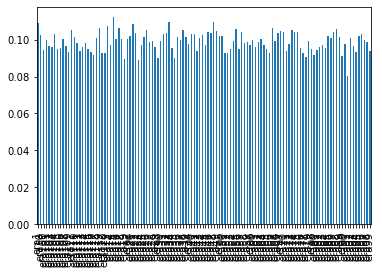

autocorrelation
0.1615675227323771
mean correlation
0.09900797769837556
sharpe
19.11548551959933
smart sharpe
16.19501087142531

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10659924788794758
0.09575984870842867
0.09679064883786484
0.11332914541685117
0.10118843338004606
0.10420926718871219
0.09447092141971973
0.1153612239448672
0.09410026173079658
0.1003073277608081
0.10729703416838948
0.1078861328772437
0.09923689418006339
0.10644374644811709
0.10360191304860654
0.10614881391890332
0.09315121116976785
0.08722119780160217
0.10006541870225862
0.10486318643032982
0.09692098662544255
0.1023901541222711
0.11063688516109445
0.10595677030058002
0.09844914365782079
0.09033882911540093
0.1000464488578561
0.09103568506765838
0.10777585766860025
0.12057481358341647
0.09430004992243383
0.09288438866125324
0.09444550377636815
0.10078344076520349
0.09951435517067354
0.10233021342744276
0.0951980773678434
0.10254514389559179
0.0953319204504071
0.0874652281211577
0.08560045743159567
0.09543760327251989
0.09675091919712694
0.09819228568604947
0.1102198487309635
0.09536635137058055
0.10185659890845722
0.10468435312887094
0.09075037479592414
0.0899

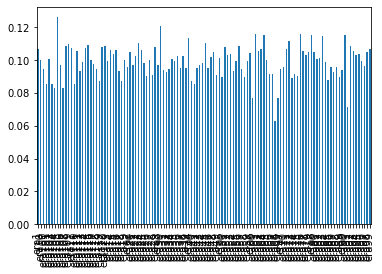

autocorrelation
0.03301340795194155
mean correlation
0.09928835236188065
sharpe
10.16696162961243
smart sharpe
9.798304502988975

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10445242192005949
0.10915800738448264
0.10530055010449096
0.10137088069754745
0.09993027100102085
0.09989178504816028
0.10571206965334753
0.10571380343800932
0.1019306678304874
0.0985296958742897
0.09801087790672564
0.10121330786105627
0.11030504280125829
0.10082204217255399
0.10353423145078969
0.10235251527503247
0.10685383107031063
0.09804909219767276
0.0894452875625286
0.10040201500743601
0.10672257781854834
0.09977214808356683
0.09970418721941705
0.10314011737827872
0.1034686531266772
0.10415630735827373
0.09794168755701278
0.09845123118551717
0.09801978598290507
0.1117714159601671
0.10259802580288965
0.10349866687582686
0.11021453515348463
0.08790380321392234
0.10319689448483695
0.09792481420570673
0.10380980728972898
0.09990424884427913
0.10558298485692431
0.09980238129778818
0.09644449420592179
0.1025243271754442
0.10599209704933063
0.11115098045963202
0.10479270679096801
0.10233475982955358
0.09684353462908878
0.10280559748242225
0.1046377614348356
0.10

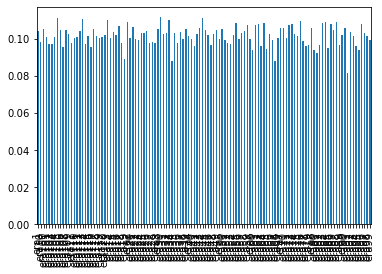

autocorrelation
-0.09460958354531887
mean correlation
0.101799268414497
sharpe
19.458439861478496
smart sharpe
21.28910133392827

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10352563782042581
0.10465289035463418
0.09456380001130828
0.11437767204611853
0.11080206513066561
0.10854705533095771
0.09642228562845635
0.10108321706431575
0.10607820477412212
0.10723745673284309
0.10893107989561862
0.10692618631385355
0.10685175026937153
0.10676235145653594
0.0952821709595828
0.10187703530124076
0.10015111041092994
0.10478674156691252
0.09774913952192676
0.11373587297286328
0.09912134186814801
0.10497772719370875
0.11161280527425942
0.09540093567892918
0.09875656953241739
0.09335359485861237
0.10430361405441642
0.10714738876075011
0.10950537159367833
0.11119086688621882
0.09521964606933746
0.09392054760890813
0.09754954001323146
0.09729290485018825
0.09507441537024153
0.10978685011464952
0.09700510404548468
0.11122460001949303
0.10520240738556486
0.10533383550453677
0.09405607702916537
0.09640769894175125
0.09808770784775042
0.10561274523036372
0.10017052533911057
0.09817798367424506
0.11046342439361813
0.09597186988091934
0.0917818027346363

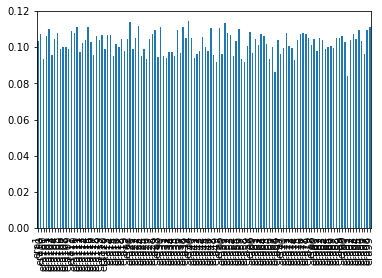

autocorrelation
-0.05015495119467863
mean correlation
0.10240321447050565
sharpe
17.179824293002603
smart sharpe
17.981254485944145

Iteration 18:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09789490726831772
0.09992898494420549
0.10329878848265273
0.10696729896870245
0.10923594891209075
0.10608716740400377
0.10460111842914697
0.11122516157264394
0.09972235978683759
0.10657177197674604
0.1022494863866788
0.10329432129646308
0.10499596802500533
0.10332595043838261
0.10863924500929847
0.11397867558113489
0.11013657113024289
0.10080396601326908
0.10356815565925187
0.11145607161783978
0.10560986984682501
0.10643284601858292
0.11044899003616891
0.1077906902244939
0.10576558842523187
0.10420358004690776
0.09856869834713838
0.09657008012183456
0.1023754870716707
0.11116021765306955
0.10610219366491591
0.10142780778532472
0.10732379245810916
0.10027268753784091
0.10260515963424838
0.1039238866259289
0.10652782399686811
0.10639106310953583
0.10108926234458286
0.10079924623532396
0.10111154036441435
0.10267935820915809
0.11025482838243428
0.1029869867052865
0.11113183595152462
0.10370551868382445
0.10230553262605954
0.10919451339447322
0.10224877545697342
0.

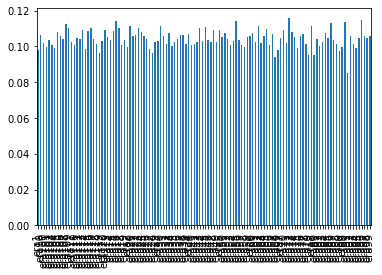

autocorrelation
-0.05552182162595834
mean correlation
0.10446767391798532
sharpe
21.719030654901402
smart sharpe
22.853855227792728

Iteration 19:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11481903959480746
0.10856812526918835
0.10660429142111918
0.10590487799597935
0.10449321682801657
0.1017720235240938
0.10124106849804698
0.10596843722235663
0.10679405288675975
0.10601944010661543
0.11167666979770478
0.1135252786634509
0.10161868256979693
0.11163529485578477
0.10195994569756277
0.1123652440079546
0.10675669112211314
0.10599092605679841
0.10860230984248513
0.10887992705621727
0.1023632102777897
0.10103211495182907
0.10592405085711287
0.10128725753174316
0.10269714070636092
0.10886509514909541
0.10695398384622526
0.10492514121341756
0.10936802149575775
0.10834411934545335
0.10175482342102232
0.10965479992414504
0.10150383684304694
0.10658869243247514
0.10665722600796577
0.11418464574201005
0.10190954288439193
0.10292826992646922
0.10908797067304346
0.10693843834818864
0.10370292843864037
0.11054746676265291
0.10333675141722544
0.11313849368522051
0.10733192191872466
0.11118835252660056
0.11398399310624632
0.10196595169578031
0.1064755414980156
0.

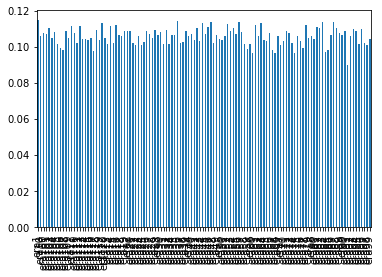

autocorrelation
0.01814017754622876
mean correlation
0.10594594614109581
sharpe
22.86111379623917
smart sharpe
22.35974687773148

Iteration 20:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10371246105978281
0.1006290170291421
0.09951200722052791
0.1151930997669188
0.11629712567044662
0.11129435099322962
0.10410634338964656
0.11657914093856665
0.09681375569313645
0.11428885318396151
0.10807298477321206
0.10930387235300032
0.10854993494982844
0.10483276569507659
0.11114379934151043
0.1126248554861397
0.10218454964210676
0.10941686107159299
0.10526812463776015
0.10859055619620432
0.10372162055762824
0.1157897018255776
0.11721605629485653
0.11222784853777101
0.10916444070188396
0.10603126039468123
0.09637292955062576
0.10710062317675675
0.10515429031289801
0.10988073770033457
0.10761213971086543
0.0993825011086199
0.10601947847844645
0.09636222257907709
0.10177682250717578
0.10960272378652808
0.10917910069146293
0.11230969968089867
0.10493661528162203
0.09969909759605343
0.1052696191575688
0.10299626308481782
0.11100958633913952
0.10988874471293672
0.10541870797266925
0.10018425966732396
0.1077538508397028
0.11506348888640718
0.10096288109273906
0.10

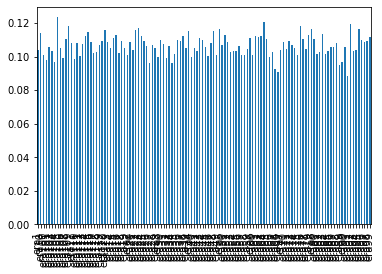

autocorrelation
0.07987694667663198
mean correlation
0.10663335908668069
sharpe
16.984199055856898
smart sharpe
15.622656557578228


In [16]:
boost_model = era_boost_train(X_train, y_train,
                              era_col=train_static["era"], proportion=0.5,
                              trees_per_step=10, num_iters=20)

In [17]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, metric='spearman')

In [18]:
gp.fit(X_train, y_train)
gp_features = gp.transform(X_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.77       0.00330205        3        0.0166929        0.0173868     68.71m
   1     2.77       0.00839278        5         0.020349        0.0170025     59.44m
   2     2.52        0.0127318        4        0.0215696        0.0121366     55.92m
   3     3.71        0.0143595        7         0.024109        0.0173198     53.69m
   4     4.06        0.0159485       13        0.0250604        0.0228604     50.21m
   5     3.82          0.01772        8        0.0256525        0.0188185     47.11m
   6     5.26        0.0184756       12        0.0264415        0.0128299     44.88m
   7     7.24        0.0185912        8        0.0270591         0.019343     42.91m
   8     8.00        0.0186224        8        0.0276338        0.0141293  

In [19]:
df = pd.DataFrame(gp_features)
df2 = pd.concat([train_static, df], axis=1)
transf_x, transf_y = clean_for_xgboost(df2)

In [ ]:
boost_mode_transformed = era_boost_train(transf_x, transf_y,
                              era_col=train_static["era"], proportion=1.0,
                              trees_per_step=10, num_iters=20)


#### Era boost train with proportion 0.500 ####

Train 20 iterations
Train 10 rounds per iteration

Iteration 1:

predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.07905266777675364
0.0664952324351671
0.044064962854627465
0.1021796447776943
0.09399276686641563
0.06076662325150385
0.05158268392826681
0.09872211482620785
0.045772024595826126
0.08637282969066347
0.10600040358212737
0.08462090097129099
0.08281559942331605
0.05315500868950984
0.058439266127539614
0.09884572364315904
0.06098340792579742
0.020737204418067038
0.0456107214604566
0.0951180340547293
0.02559091824555327
0.09774827305690854
0.11832124501794736
0.08151341326857282
0.050039180351485586
0.03401702453579571
0.03699003928258879
0.06532313715348784
0.07042074544128872
0.100370133773391
0.060570526005608666
0.0263778612961944
0.034258612745997036
0.07138980762616048
0.04657354219433728
0.10029408251977573
0.09144242142137263
0.06576049905635992
0.0719996041124231
0.04368709677802317
0.008563151608480481
0.05025774778074721
0.05454193762944482
0.07256535428142305
0.09269426712736871
0.023387982778673384
0.0695085033156311
0.10425702148979775
0.037167855082232

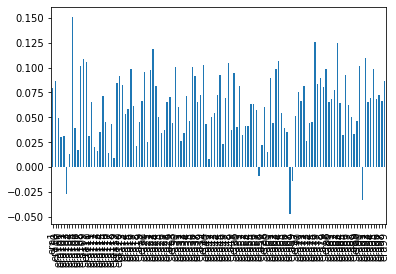

autocorrelation
0.13945931542731008
mean correlation
0.059529523720353396
sharpe
1.7528568207012751
smart sharpe
1.518731269647241

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.07445417530213456
0.055160070697044344
0.06288307847019158
0.05191636411909566
0.04163427834147217
0.09513913589481646
0.09203852942451399
0.0464004234914387
0.09505174442523563
0.05781832308839763
0.060994575008525356
0.07017782289608364
0.06511008649713797
0.08917074662897848
0.11397633649065879
0.08790951150127355
0.11669409362105543
0.07800075199778501
0.07411673682463867
0.06815669184763284
0.08454234781546617
0.0751121710104692
0.07067908282210049
0.06729177141757707
0.07698988097354516
0.09360306176561567
0.0877534017882228
0.04869027558333678
0.035253453121274585
0.06639787332329335
0.09055114125345416
0.07882299374824223
0.10190993411215471
0.029925170471315304
0.07142383060315526
0.07323119186970592
0.06742195204504205
0.049449263913014484
0.05995122371286914
0.08627601142967509
0.07323242458400156
0.08377492637835011
0.1052014406835923
0.05787058954152412
0.05375614011232406
0.06270867907434904
0.04239726809108673
0.08822763849607379
0.09225694234123

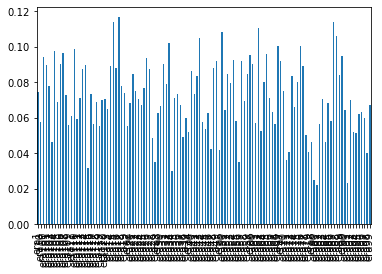

autocorrelation
0.17712247124914357
mean correlation
0.07117487862052463
sharpe
3.403275228095901
smart sharpe
2.837915802922058

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.04167029171019816
0.07233518707835639
0.07092422977591098
0.12062080773219538
0.10516021827487654
0.06698687224626823
0.058387229061556405
0.12036967715340564
0.04496994768546938
0.08424818034957667
0.10167055322768011
0.11809230859542709
0.08048731885139368
0.05274438220816347
0.06255772961570202
0.10348853951899598
0.05135602827965998
0.036541761754647996
0.06933703956711824
0.08964222538155203
0.03772012978351935
0.0970917309844058
0.09481823307610279
0.0849728010408655
0.06912850694612363
0.04476346038271604
0.03905266908350679
0.08134486544416755
0.08552499903049808
0.11186523966236074
0.05737888302612438
0.02716845074705597
0.04114454129177399
0.08060793656226255
0.06186178215613515
0.09664011141133555
0.08721789962206851
0.08244407688978289
0.08305957687467669
0.04890723261702784
0.027735526312166553
0.046378264074389705
0.07036527865706124
0.07798557679282771
0.09757945414508895
0.04592485234989405
0.09136110181083648
0.09527045256649387
0.0453015030577

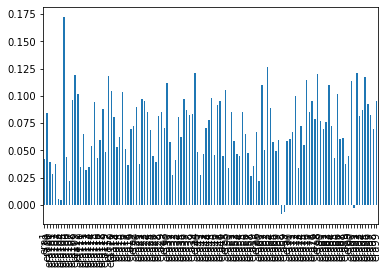

autocorrelation
0.04262043796697414
mean correlation
0.06829748533189176
sharpe
2.1742441356621782
smart sharpe
2.075509417507218

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08545791739577976
0.07557055693189646
0.048137095986627014
0.0919196787161343
0.08940276278036728
0.09143691867295362
0.0770927343338685
0.07807377566812375
0.07430587376475492
0.08527629523839397
0.09382160608783821
0.09160414079029892
0.06783997127937995
0.06907867882355596
0.09734319315033557
0.09547575263434956
0.09196719102343899
0.06574508033116036
0.045767013215810615
0.07596110248830905
0.0632783671181717
0.07631561839750849
0.08127625794075237
0.07966498918353902
0.07925992673505797
0.07944180721081469
0.06742149503963997
0.06391037370265387
0.06994512495770626
0.09868933230369255
0.08718213133823026
0.060142361871236304
0.07440112374380363
0.05577241285490064
0.06703566858584964
0.07961031223843489
0.0729885935578275
0.08293435288609229
0.09025814259436751
0.08054096746217446
0.06505950053798522
0.07405198030001305
0.06333724023758498
0.06861088618997387
0.0809909786471144
0.08020096555720001
0.07684382916463002
0.08591351410202172
0.06107614239708448

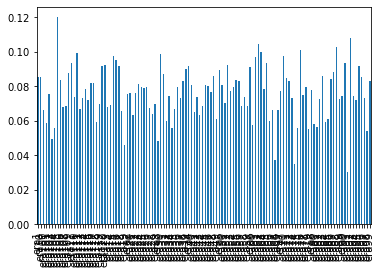

autocorrelation
0.03708026199105424
mean correlation
0.07606528366360021
sharpe
5.007119509794094
smart sharpe
4.806114347613142

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.0862142308697941
0.09752493006650882
0.06350699140397176
0.09100823248167488
0.08688109162924255
0.08726176444379548
0.06860742707323145
0.07866825055054763
0.08253648604062046
0.0837384309736348
0.0862076709488848
0.08975262827727984
0.0884245515158297
0.08181130509368577
0.08423039757535315
0.08746758749444528
0.07697832516400727
0.08060498661326936
0.06735104503646297
0.0981005697732909
0.07771512484200496
0.07741195246704688
0.07739912837307933
0.06745427924988642
0.06406886718084959
0.06432249232933554
0.08873154563827326
0.0873819514007737
0.08815828414620583
0.09044135479875838
0.06930631276549382
0.06721502320506566
0.09016382571939774
0.07773052226124855
0.07917181220080619
0.08046592845260181
0.09726526782035991
0.06940093915622449
0.08368286626964529
0.07524095346864619
0.08013567259601223
0.08020547140535102
0.08491240629713218
0.0916307535800547
0.07676244563648962
0.05931479767267366
0.07124156128969952
0.08576478505762798
0.07393818181260498
0.06

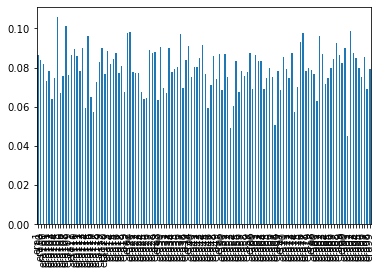

autocorrelation
-0.06811164001510438
mean correlation
0.07897035245674393
sharpe
7.16824321935943
smart sharpe
7.637908627942819

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.07454579613514735
0.07996428177286051
0.07041655900924147
0.09736990737928987
0.09348065565134539
0.08223109641027768
0.07898746336295531
0.09991051985487033
0.06341868131415773
0.08376901280661538
0.08515861454820682
0.08627396834431628
0.07614034911664144
0.06867949412810335
0.0751525831461907
0.09270935578177789
0.08567811673813526
0.07789746269305263
0.07625955808089906
0.085085015837951
0.07108354332416003
0.09315966432409963
0.10338435050585763
0.09365881067001124
0.08235230316996756
0.08577594265576166
0.06957598373998923
0.06977156377893966
0.07700593327553593
0.08785271909855022
0.0826058613001986
0.0751294135160818
0.06737164142211391
0.0869635849152388
0.06149801964286163
0.08220226372078841
0.07988380371907532
0.09152165669624403
0.08501486634729291
0.08588143584711555
0.060298688715532824
0.06642646538782045
0.0733814949788328
0.08200690353037014
0.09391192263360014
0.06357115854432285
0.08982166239369069
0.0868815824024284
0.07944229481945712
0.07

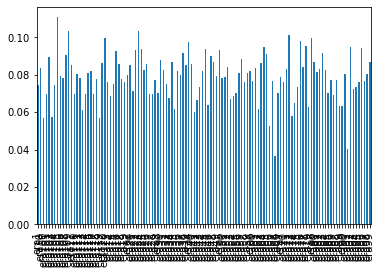

autocorrelation
0.02764792269117175
mean correlation
0.07879558728176086
sharpe
6.360633835014708
smart sharpe
6.162728176220601

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09886947696471403
0.08306884029849103
0.08651420670641441
0.08377728025980452
0.0869414877330683
0.08484591064054998
0.09085097235007066
0.09323908792011364
0.08007103872000586
0.08077712887696009
0.08223959447050916
0.08733550527132977
0.09047244050291314
0.0833675027714574
0.09822624902743896
0.08860246572522439
0.07607647364086101
0.08930589168796817
0.09367264353063288
0.09015613953586138
0.08587449939075266
0.0908637724798351
0.09819507420571902
0.08278340326267038
0.07010505850989227
0.07384818033225266
0.09173298251423063
0.09213893186050379
0.08911190836846511
0.08966338583636425
0.07508011221245196
0.08510585355179161
0.08665619776289557
0.07413587768824963
0.07334467257324553
0.08049653053188048
0.08268820674165914
0.08673320492496092
0.08039171478122557
0.08117843521606524
0.07331765614038403
0.07691445003849848
0.08768136230248708
0.08043765150152188
0.08530494047263175
0.08032661491809323
0.08088554873823135
0.0831575589971309
0.09229389043824378
0

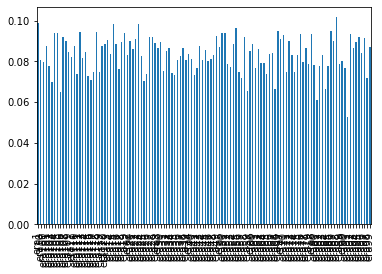

autocorrelation
-0.011975635610992373
mean correlation
0.08338989670047135
sharpe
9.612480950603555
smart sharpe
9.686707986497433

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08934428026203409
0.08561392154599934
0.06731184271439372
0.10838439290972679
0.08812871498156356
0.07757795630470204
0.07817524281100571
0.09201840357880409
0.08410327438172928
0.09059418321209194
0.10073762603491924
0.08823820095942864
0.07913168001323748
0.08731938261440246
0.08606324070612277
0.0935571699632373
0.07904845167270658
0.07937348947408937
0.07325609694444649
0.07913777208215252
0.06555404504476298
0.09264258922530624
0.10012968389965668
0.09561225746256596
0.08344295913495983
0.08037911874400688
0.07419073945093561
0.07670145596748752
0.08312045956242142
0.08937400658111049
0.08560223096970239
0.06727943094042263
0.06424986815880511
0.08671677584306302
0.0763169684578178
0.09946172390896102
0.09050346345910282
0.08040432826831068
0.09386325007221295
0.08378048420705993
0.07127840230484055
0.08749351665948737
0.077051540274511
0.09147567550529438
0.08353746502335212
0.07565714177412612
0.09541077082158117
0.10363223538849942
0.07044758030605817
0

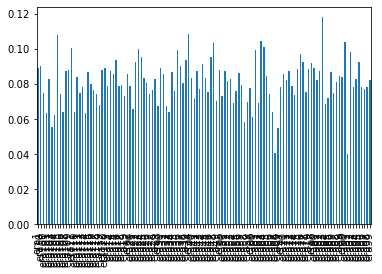

autocorrelation
0.03851443772727245
mean correlation
0.08134858042617804
sharpe
6.380672961041344
smart sharpe
6.11581159447771

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08545558128662582
0.08178786969532452
0.0734386395597501
0.08978862263160847
0.08451302767914974
0.09482054628092168
0.08873355260959129
0.08406799840326055
0.07626845953502955
0.09101037183412587
0.09035462300128409
0.08348210426915283
0.09214269504255986
0.0819530990218924
0.08200676967004299
0.09447150848087306
0.09696341157857485
0.09128028070888955
0.08269904831359652
0.09706516332751056
0.07668741750831538
0.09243945299830346
0.09193397914360717
0.09170276137625435
0.07150515946972713
0.09449685978004327
0.09348206245603945
0.08901293591002006
0.07512208519059149
0.08244815531779895
0.07804214652018855
0.07907728607760396
0.08590942183429612
0.07288065502382954
0.08388220866378496
0.09274269300192027
0.08984221031389773
0.09568791550185818
0.09199167831409301
0.08277507178565512
0.0872537987941862
0.07596205421733673
0.08853197462169671
0.08969954007567994
0.0772529890519426
0.082560717572627
0.08950956210473872
0.10083840145512821
0.08489804515392962
0.0

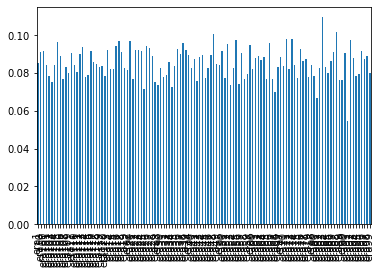

autocorrelation
-0.1118314376889405
mean correlation
0.0853256765464083
sharpe
10.625584177804761
smart sharpe
11.827636788659333

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08358964354819445
0.08974926707316802
0.08239194769497062
0.09985451817621724
0.09618914450309923
0.08247418432558803
0.07809896821489168
0.0959276835340901
0.08325851597151224
0.08758677716194702
0.09025547036534316
0.09977912247716574
0.07879849919213157
0.08755472874212632
0.09042006337739801
0.0957395149887476
0.08231535683095435
0.0789005936378684
0.0874709357124309
0.08719297144526013
0.08065842027089204
0.082818664765995
0.0933482663197597
0.085668931141804
0.08299844141650119
0.0796295012709476
0.07973975443113451
0.08321975951605777
0.08717670729882637
0.09559667971002646
0.0858563112185897
0.08352167487708854
0.06966146393894353
0.0807677501222033
0.08755778275681311
0.09141925994137759
0.08051350654177065
0.08821737202829459
0.08872622418475293
0.08729387751692125
0.07230238168043462
0.08481986321688774
0.07952082714306903
0.07912716388119212
0.09196275323392898
0.08825467311367087
0.08505158377589679
0.10118355530329626
0.07120179444553236
0.0789339

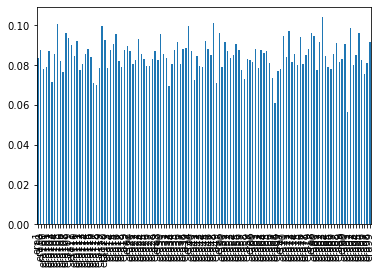

autocorrelation
-0.006593157051628455
mean correlation
0.0848090681740959
sharpe
10.746440120965895
smart sharpe
10.771769036269607

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10120886280515527
0.08947341006569731
0.08619796109341632
0.0932147076024139
0.09782853230060906
0.093738647553851
0.08831821045067414
0.09034445329998829
0.09300799410389092
0.0858449077579869
0.08136674440396868
0.09426361080508469
0.09425778688249543
0.08173569390538533
0.08712484557953518
0.0940584616486608
0.09807824130812205
0.09540878786435615
0.0768143851928196
0.083841861717811
0.08773880831206762
0.09729956295188812
0.08623563522522483
0.08389580865515517
0.0887567932929391
0.09441554629978663
0.09209989146832656
0.09033460902878462
0.08074730980094479
0.08962494004914445
0.08015096034245203
0.08970929808895503
0.08301030779544048
0.0882725152156933
0.07787773761221575
0.09057895977446978
0.09356220783568131
0.08684997793003933
0.08700505236550961
0.08485488800443156
0.08093989287863003
0.0914775922495244
0.09008463567373279
0.09934861794598956
0.08587189841483019
0.0774907446504719
0.08166797137716861
0.10077806525975931
0.08220529887868348
0.0915615

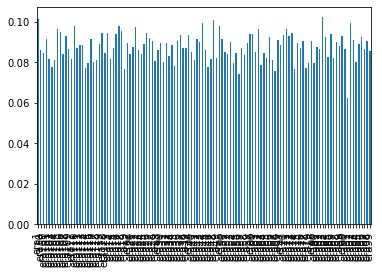

autocorrelation
-0.08040291889964722
mean correlation
0.08748205449925821
sharpe
13.241914940027558
smart sharpe
14.283513512961976

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.0942724423295832
0.07893909361111147
0.08907662671730493
0.09543733406982152
0.09745045582631648
0.0860258082848482
0.075469473892297
0.09360387687988649
0.07937187734888032
0.09116749309493592
0.10180917498917595
0.09649069675055055
0.08202017139569806
0.08437713255149104
0.09453177720138606
0.09511722947139109
0.08074498574858559
0.080496003386938
0.08096648853700603
0.08871608485242874
0.07362082304481898
0.0938679869714462
0.10076253992892403
0.09290419478543148
0.08244709652033272
0.08093778663967674
0.07906976908394166
0.08058685308401481
0.08583767226652804
0.09052348407440192
0.08746262776139954
0.07308522618800747
0.08274022194047494
0.07592432081518556
0.08245498403432885
0.08924891781045094
0.08604137099107778
0.09388193494046537
0.09301553536909468
0.0841826274547575
0.08227157600444664
0.07974388497769326
0.07846642801243443
0.08608597433947414
0.09461891801515977
0.0763892399682284
0.08809128298494173
0.09966077955982242
0.08226820728754021
0.0749

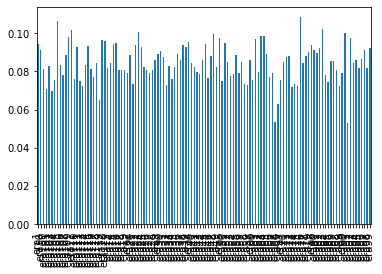

autocorrelation
0.06211863605764971
mean correlation
0.08458666732120672
sharpe
8.716049667933246
smart sharpe
8.160481710135022

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09698650605347009
0.09255654920867924
0.07872715638194229
0.08813818871272393
0.0920766558665657
0.08263393627912474
0.087304653661152
0.0840846180305728
0.09118735417557346
0.09155677922873987
0.09554646135365623
0.09159819895201675
0.08863689570149064
0.0923896081161755
0.09062698237730675
0.09327112330199235
0.09360220550216564
0.09533365449832505
0.08830055904386161
0.08900075478696032
0.08384896679839172
0.08994597635867076
0.09427013090302543
0.08958229012154363
0.08910863635629035
0.0928734360022825
0.09279420323370105
0.08841474050392047
0.08342658739661583
0.08597632360284917
0.081654238276576
0.08176721859999969
0.0925441421834344
0.08361741570892103
0.08698484513369051
0.08389599458748748
0.08293080657869498
0.09297740289435215
0.09215577841965128
0.09713550781814263
0.09241200571453578
0.08940360029052499
0.08621873974673125
0.0832056637691949
0.08892805682399348
0.08785171082690982
0.08505248950870048
0.09559665487942152
0.09175055904796328
0.08962

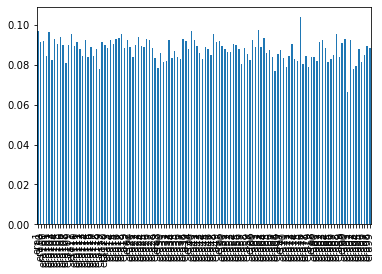

autocorrelation
0.03978341000391073
mean correlation
0.08784590758687684
sharpe
16.541476388466393
smart sharpe
15.834871549159802

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09226944759283412
0.08418491719715966
0.0889731222903647
0.10370682826865839
0.09147854641524997
0.09246414799084614
0.0905314078603603
0.09671862247304697
0.08049300652934648
0.08914260894319546
0.09578034535767391
0.09378252886738551
0.08655030240135018
0.08335392267892827
0.0813447172344383
0.09435452319335162
0.08405159368648385
0.08139432311369933
0.09490328289151906
0.09155142846077369
0.08280507933293293
0.09358999312821827
0.09671674294536604
0.0834191230608949
0.0837453594231103
0.08103743954399432
0.08283071287699531
0.08643515398744533
0.09144335247274604
0.10405455512139065
0.08469478082654419
0.08483000831303618
0.07905468186442828
0.09215144431610851
0.09139645120517155
0.097408765780648
0.09524878305318464
0.08685366599847537
0.09031190620078822
0.08856366190271768
0.07492330104461277
0.08092303110865276
0.09726033273074569
0.09271958986005098
0.08883121671479394
0.08897260209193539
0.0938734505781218
0.09414254673389731
0.08218523360040385
0.078

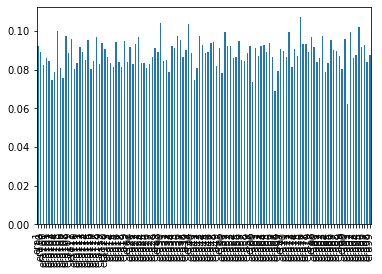

autocorrelation
-0.1072183135007344
mean correlation
0.08845676319201698
sharpe
12.389953747257128
smart sharpe
13.72790743720158

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09479353994304669
0.09337988339418773
0.0792979844932667
0.09582032480592714
0.08821091347675453
0.08854622234857729
0.08707837290388527
0.08967724769243288
0.08843133442012756
0.08882616158822779
0.092210229395976
0.08773240310705613
0.0975009162978013
0.08975335064602588
0.09195315637086694
0.09353510698779523
0.0974457872404175
0.09663016799541692
0.08454667314327913
0.0878958982784159
0.09242234981832365
0.08874528718243024
0.09171106243725731
0.09753492943233255
0.08889956600838031
0.0943694909767452
0.09496792333967723
0.09128051750473562
0.08619589738574046
0.09668458908977531
0.09391411774622047
0.09037181536635337
0.08882600335940385
0.08490120647613157
0.08128738408979884
0.09339708982611247
0.0896445898745327
0.09771840219516617
0.09027217991327686
0.09817580368257474
0.0841586127597135
0.08928657073266005
0.08941177253431266
0.09128807108258762
0.09531591219416005
0.08395486544345351
0.09125312755302732
0.09510690733093467
0.08972341715679817
0.0910

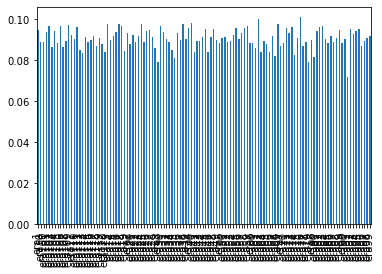

autocorrelation
-0.11150054614331087
mean correlation
0.0906834117785035
sharpe
18.986780922391212
smart sharpe
21.127700150873387

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08680417099600067
0.08637075760728462
0.08491599118847416
0.10115680313377529
0.1013055611158633
0.09431125966596857
0.08851179233375786
0.10723190895463665
0.09076506132101268
0.09290738900873687
0.09324514165451762
0.10664583561387089
0.09028374912823815
0.09419746087685085
0.08654723679695209
0.09630767620515086
0.08603952657405356
0.08074874921297222
0.0934393226771638
0.09370162540758681
0.07762636217953472
0.10254680039577606
0.0933675793974853
0.09379972001746512
0.09759664183596285
0.08277263238245933
0.08172925839932667
0.0863745316684035
0.09430810577366594
0.10225358062331724
0.08969609253799476
0.08750373573349524
0.08841200735322399
0.08963523303919595
0.08998611974904752
0.09729462412498022
0.10016893033525096
0.0927849993603963
0.09557890580050815
0.08586150181035061
0.08436142535613203
0.09011922912069614
0.09690255790313371
0.08517499585492735
0.09525401459165843
0.08080459861541306
0.08702201836745156
0.09787332035089011
0.09318720815104024
0.

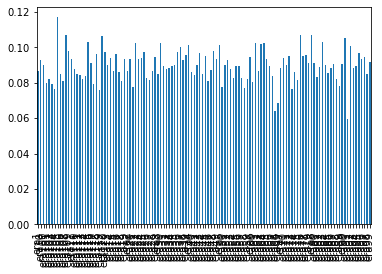

autocorrelation
-0.04970439852311743
mean correlation
0.08982215946419836
sharpe
10.105378152622212
smart sharpe
10.572052705756215

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09956508134211968
0.09453587163861535
0.08927388310116276
0.09102592436288968
0.09538347502433353
0.09306019461983946
0.098492191291203
0.0965252765657467
0.08717901234147184
0.09291354385264575
0.08888624567561898
0.09896363692394236
0.08524919098021491
0.08760272150970401
0.09795560639390688
0.09469499577826518
0.09839689298971811
0.09389154376437293
0.0851205549112712
0.08997798150137262
0.08809851919149944
0.09595459018130144
0.08802384303678505
0.09190223818095088
0.08993790277350769
0.09406936340884241
0.09540131056302563
0.09486973014442007
0.087275210160928
0.09547655167418041
0.09532040139689452
0.09559413689554748
0.098129374646321
0.0954900281675845
0.07984191912439793
0.0922874371493876
0.09509600195001677
0.09156057755123198
0.09440638095114076
0.09644019560245776
0.09595544392947802
0.08601433315072063
0.09124939600973261
0.09540969360466967
0.09157072304755302
0.08939181782019677
0.09683426432613446
0.09541595489407151
0.08961532667847849
0.08952

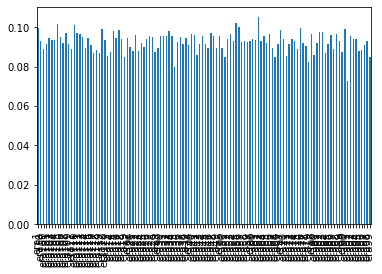

autocorrelation
-0.05507764409398016
mean correlation
0.0926395115801219
sharpe
19.676821645739654
smart sharpe
20.695794721902526

Iteration 18:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.0963624407429502
0.08755247765003982
0.09348780186606488
0.10704149078671028
0.09888994772855748
0.1017722044133116
0.08975276434546477
0.10102971968002122
0.09156725278592862
0.10004292773098908
0.10333444102339649
0.0999011284151014
0.0958577231349814
0.09210847358262876
0.09169244777734059
0.09502080527561735
0.09096599724852579
0.0854823983286088
0.09089532754391444
0.1023296615589036
0.0873584419003834
0.09791007378476219
0.10082481926067524
0.10001067497775588
0.09954407553665783
0.08504740511273012
0.08360253735907489
0.09214734722415255
0.09880410326227271
0.10057850608369256
0.09068834417156672
0.08827383692607531
0.08728641446224968
0.09303117417742145
0.0883981512861757
0.10468428763521954
0.09292299762842136
0.09893035994390421
0.09267081765897606
0.08810857678040232
0.0847088813364486
0.0904054767102763
0.09734277912068144
0.09462918723147185
0.10139959412672397
0.09234086713660873
0.09465850029307975
0.09307210010300894
0.09344789562973649
0.09242

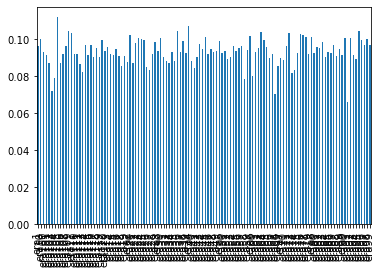

autocorrelation
0.037323219570416434
mean correlation
0.09341733477286997
sharpe
13.140661874380957
smart sharpe
12.610102152954893

Iteration 19:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09478222922725174
0.09799672176451725
0.08686823858688565
0.09878476662362418
0.09615655432270408
0.10066320097981402
0.09935224030594453
0.09424283783000958
0.09976145567341374
0.0997259762872017
0.10124878183839028
0.09559283187680115
0.09655532170110108
0.09955118563090631
0.10369950853115831
0.09103891087387349
0.10212976310542737
0.10109748736149743
0.09650236469626665
0.09869624032102381
0.0948090723390208
0.09661111245564158
0.09816462830242825
0.10006577283909343
0.09382604985607408
0.09784244448558564
0.09665285803148284
0.09714656116499117
0.09502511696931117
0.09434768577884758
0.0990056468129018
0.09502576122911283
0.09743269225648155
0.0972169271193818
0.09363774620265987
0.09957640053954345
0.10018802999928635
0.09834085731827055
0.10063102452327484
0.09886542364112058
0.09580766950148903
0.0983613511419369
0.09516536280771903
0.09429827253769624
0.0990502314247031
0.099472575734272
0.09200263334527786
0.10247694790067692
0.09430246078838997
0.103

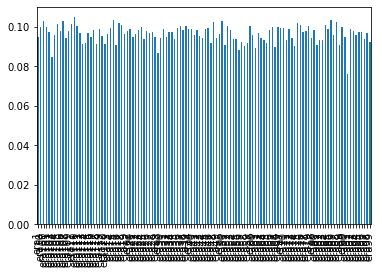

autocorrelation
0.01726472374048876
mean correlation
0.09649163125622409
sharpe
22.662039624223
smart sharpe
22.184295607971748

Iteration 20:

fitting on worst eras
predicting on train


<ipython-input-14-d3aaab886d99>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10372942624080503
0.09044079614139221
0.08897198361772805
0.10117913304239343
0.10658096150716671
0.0977612308054278
0.09178092305212848
0.1064631860817484
0.09237653457546248
0.09534657656081238
0.09800227640500148
0.1061818041448884
0.10096302625501527
0.09497413873804852
0.09472665918024627
0.10352637619574002
0.09301697087624329
0.08851553339518495
0.1002327982248381
0.0953414700126791
0.093396800020305
0.10657371235816329
0.09647380857945329
0.09511781572914493
0.09945781866844147
0.08838715496255077
0.09836883793073943
0.10153326717196076
0.09928242258807753
0.10364896974524206
0.09359677684950467
0.0926354550736987
0.08992369999637034
0.09315872301251397
0.09570666608582326
0.10089348620026345
0.09744788604286628
0.09157969633625652
0.0952554169702212
0.0894948547439015
0.09587651021928857
0.09177087916860968
0.0987111491554023
0.09822904580853611
0.09727518990202919
0.08980815220691066
0.09727116454167277
0.10323371419641175
0.09427874916941338
0.093009

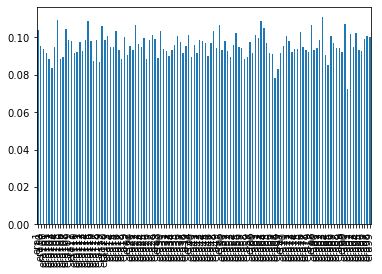

autocorrelation
-0.042504939295514084
mean correlation
0.0958207823167152
sharpe
15.344718642065878
smart sharpe
15.938906485063548


In [21]:
boost_mode_transformed5 = era_boost_train(transf_x, transf_y,
                              era_col=train_static["era"], proportion=0.5,
                              trees_per_step=10, num_iters=20)

In [24]:
df4

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,0,1,2,3,4,5,6,7,8,9
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.50,...,1.25,2.00,1.00,1.75,1.75,2.00,2.00,2.00,2.00,2.00
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.00,...,0.25,0.25,0.00,-0.50,-0.50,0.25,0.25,0.25,0.25,0.25
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.00,...,-0.50,-0.75,-1.00,-1.75,-1.75,-0.75,-0.75,-0.75,-0.75,-0.75
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.00,...,0.50,0.50,-0.50,0.25,0.25,0.50,0.50,0.50,0.50,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.50,...,0.50,0.75,0.25,0.50,0.50,0.75,0.75,0.75,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698476,nffb0e4e60b166ea,eraX,live,0.25,0.00,0.25,0.50,0.5,0.25,0.25,...,0.25,0.25,-0.50,0.00,0.00,0.25,0.25,0.25,0.25,0.25
1698477,nffc2bf82af58f1c,eraX,live,0.25,0.25,0.50,0.25,0.0,0.50,0.75,...,-0.75,-1.50,-1.50,-1.50,-1.50,-1.50,-1.50,-1.50,-1.50,-1.50
1698478,nffea596c525e547,eraX,live,0.75,1.00,0.50,0.50,0.5,0.25,0.00,...,-0.25,0.25,-0.25,-0.75,-0.75,0.25,0.25,0.25,0.25,0.25
1698479,nfff3afb5a848263,eraX,live,0.50,0.25,0.25,0.50,0.0,0.50,0.50,...,0.00,-0.50,-1.00,-0.75,-0.75,-0.50,-0.50,-0.50,-0.50,-0.50


In [28]:
# tournament = tournament_static.copy()
# gp_features_tournament = gp.transform(X_tournament)
# df3 = pd.DataFrame(gp_features_tournament)
# df4 = pd.concat([tournament_static, df3], axis=1)
# df4.drop(['id', 'era', 'data_type', 'target'], axis=1, inplace=True)
# tournament.loc[:, 'prediction'] = boost_mode_transformed5.predict(df4)
# current_round = NAPI.get_current_round()
# tournament.set_index('id', inplace=True)

tournament['prediction'].to_csv(f"../../submissions/burningcrusade/boost_mode_transformed5.csv", header=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../submissions/burningcrusade/boost_mode_transformed5.csv'

In [ ]:
train = train_static.copy()

In [ ]:
features=generate_features_list(train)
train['sum_feat'] = train[features].sum(axis=1)

In [ ]:
def gfl(df):
    return [c for c in df if str(c).startswith("feature_intelligence")]
intel = gfl(train)
for col in intel:
    gb = train.groupby('era')
    for name, group in gb:
        
        cor_cof = np.corrcoef(group['target'], group[col].fillna(0))[0][1]
        print(col, name, cor_cof)

In [ ]:
train_intel_poly, tournament_intel_poly = generate_polynomial_features(intel, train, tournament)

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(boost_model.feature_importances_,features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:310])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
boost_model_1 = era_boost_train(X_train, y_train,
                              era_col=train_static["era"], proportion=1,
                              trees_per_step=10, num_iters=20)

In [ ]:
tournament = tournament_static.copy()
# gp_features_tournament = gp.transform(X_tournament)
# df2 = pd.DataFrame(gp_features_tournament)
tournament.loc[:, 'prediction'] = boost_model_1.predict(tournament[features])
current_round = NAPI.get_current_round()
tournament.set_index('id', inplace=True)
tournament['prediction'].to_csv(f"submissions/burningcrusade/gplearn.csv", header=True)

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(boost_model_1.feature_importances_,features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:310])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()